# **Minimum Set Cover**

# Introduction
**Set Cover (SC) Problem**:   

- **[Instance]** Set Universe U = {$u_{1}$, $u_{2}$, ... , $u_{n}$} and a family S = {$s_{1}$, $s_{2}$, ... , $s_{n}$} of subsets of U.
- **[Feasible Solutions]** A subfamily C  $\subseteq$ S such that union of C is U.
- **[Value]** The value of a solution is the size of the cover |C|, and the goal is to minimize it.

**Weighted Set Cover Problem**:   

- **[Instance]** Set Universe U = {$u_{1}$, $u_{2}$, ... , $u_{n}$} and a family S = {$s_{1}$, $s_{2}$, ... , $s_{n}$} of subsets of U with a weights array W.
- **[Feasible Solutions]** A subfamily C  $\subseteq$ S such that union of C is U.
- **[Value]** The value of a solution is the weighted sum of the cover: $\sum$ $w_{i}$ for all i such that $S_{i}$ $\in$ C, and the goal is to minimize it.
---
      
**Implementation:**   
We use two metrics for the comparision of algorithms:
1. Performance Ratio: ratios of lengths of vertex covers (wrt Brute force or ILP).
2. Execution time of various algorithms.

# Import

In [ ]:
%%capture
import networkx as nx                   
import matplotlib.pyplot as plt 
import pandas as pd
from tabulate import tabulate
import random
import numpy as np
import scipy
from scipy.optimize import linprog
from mpl_toolkits.mplot3d import Axes3D
from math import inf
from math import ceil
import warnings
warnings.filterwarnings("ignore")
import time
import itertools
import copy
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','svg')

In [ ]:
%%capture
!pip install mip
from mip import Model, xsum, minimize, BINARY

# Problem Set Generation
The generate_sets function generates two sets, that is a universal set (U) of size n and a family of subsets (S) of size m.

Weights are generated randomly from MIN_WEIGHT to MAX_WEIGHT.

**Implementation:** 
- Universal set is given by list [0...n], while we generate the family of subsets by randomly deciding if we include an element in a subset i or not.   
- This does not guarantee that a set cover is possible, so we check if the union gives universal set, if not then we add missed elements to randomly chosen subsets.
- Our earlier implementation allowed some of the generated subsets in the family of subsets to be same - this reduces the value of m and hence can affect the graphs.
- The family of subsets is now a set, and hence ensuring uniqueness.

In [ ]:
def generate_sets(n,m,PROB = 0.5):
    universal_set = [x for x in range(n)]
    family_of_subsets = set()
    
    while (len(family_of_subsets) < m): # Ensure size is m
        # Temporary list
        temp = []
        for vertex in universal_set:    # 0...n
            # Higher the prob, more number of elements in a subset 
            if random.random() >= PROB:
                temp.append(vertex)

        # Typecasted to tuple, since set cannot have lists 
        family_of_subsets.add(tuple(temp))
    
    # Check if union is universal
    union = []
    for subset in family_of_subsets:
        for vertex in subset:
            if vertex not in union:
                union.append(vertex)

    # Typecasted to set, to check if both lists are the same
    if set(union) == set(universal_set):
        return universal_set,list(family_of_subsets)

    # Add missed vertices to a randomly chosen subset
    diff = list(set(universal_set) - set(union))
    for vertex in diff:
        # Pick any random subset from the family
        random_i = random.randint(0,m-1)
        i = 0
        for subset in family_of_subsets:
            if random_i == i:
                # Make a copy of this subset
                subset_copy = list(subset)
                # Delete this subset
                family_of_subsets.remove(subset)
                # Add the same subset appended with the missed vertex
                subset_copy.append(vertex)
                # Typecasted to tuple, since set cannot have lists
                family_of_subsets.add(tuple(subset_copy))
            i+=1
    return universal_set,list(family_of_subsets)  

def generate_weights(family_of_subsets, MIN_WEIGHT = 1, MAX_WEIGHT = 25):
    weights = {}
    for set_i in family_of_subsets:
        # As a list is not hashable, it is coverted to a tuple
        weights[tuple(set_i)] = random.randint(MIN_WEIGHT,MAX_WEIGHT)

    return weights

# Exact Algorithms

## Brute Force

### **Algorithm Brute Force**
**Input:** Universal Set ($U$), Family of subsets ($S$) and a weights array.   
**Output:** A set cover.

1. Iterate through all subsets of Family in order of size.
2. Check if our subset is a set cover.
3. Calculate the cost function and store it's minimum
---
**Implementation**
- If no weights are passed, we create an array with all weights = 1 to have a common implementation for weighted and unweighted case.
- Initial implementation was generation of all permutations of all lengths, which took more time.
- This was later pruned by generating permutations in increasing order of length, and breaking when we get a set cover (this will be smallest for the unweighted case). 
- For weighted, we continue to generate all permutations (no early stopping).

In [ ]:
def check_if_set_cover(universal_set, subsets):
    vertices = set()
    for subset in subsets:
        for vertex in subset:
            vertices.add(vertex)
            if len(vertices) == len(universal_set):
                return True
    return False 

class Brute:
    minSize=100000
    set_cover=[]

def subsets(universal_set, family_of_subsets, weights, brut):
    MIN_WEIGHT_SUM = 100000
    for i in range(1,len(family_of_subsets)+1):
    
        # Generate all subsets of a given length i
        subsets_i = list(itertools.combinations(family_of_subsets, i))
        
        for subset in subsets_i:
            if (check_if_set_cover(universal_set,subset) == True):
                weight_sum = 0
                # Weights: {(2,3,1,4) : 12, (1,2,3) : 15}
                for sub in (subset):
                    # As a list is not hashable, it is coverted to a tuple
                    weight_sum += weights[tuple(sub)]
                
                if (weight_sum < MIN_WEIGHT_SUM):
                    MIN_WEIGHT_SUM = weight_sum
                    brut.set_cover = list(subset[:])

                    # Breaking condition for unweighted - Check if all weights are 1
                    if (set(weights.values()) == set([1])):
                        return

def brute_force(universal_set, family_of_subsets, weights = {}): 
    brut = Brute()
    if len(weights) == 0:
        for i in range(len(family_of_subsets)):
            # As a list is not hashable, it is coverted to a tuple
            weights[tuple(family_of_subsets[i])] = 1

    subsets(universal_set, family_of_subsets, weights, brut) 
    return brut.set_cover

## Integer Linear Programming
**Input:** Universal Set ($U$), Family of subsets ($S$) and a weights array.   
**Output:** A set cover.


$\begin{align}
\text{min} \quad & \sum_{i = 1}^{m} w_{i} x_{i}, \\
\text{subject to} \\
& \sum_{i:v \in S_{i}} x_{i} \geq 1, \forall \ v\  \in \ U \\
& x_{i} \in \{0,1\} \quad i =1,2,…,n \\
\end{align}$

---

$x_{i} = \begin{cases}
& 1 \quad \text{ if the set S$_{i}$ is included in the set cover, }  \\
& 0 \quad \text{ otherwise}.
\end{cases}$

$w_{i}$ is the weight of the $i^{th}$ set

The first inequality implies that for every element $v$ in the universal set, we are including at least one subset which contains the element $v$ in the set cover.

---
**Implementation**
- If no weights are passed, we create an array with all weights = 1 to have a common implementation for weighted and unweighted case.


In [ ]:
def ilp(universal_set, family_of_subsets, weights = {}):

    mod = Model("ILP-Set Cover")
    n = len(family_of_subsets)

    # Xi's || set of sets => subsets 
    x = [mod.add_var(var_type=BINARY) for i in range(n)]

    if len(weights) == 0:
        for i in range(n):
            # As a list is not hashable, it is coverted to a tuple
            weights[tuple(family_of_subsets[i])]=1

    # objective function: minimize the cost
    mod.objective = minimize(xsum(x[i]*weights[tuple(family_of_subsets[i])] for i in range(n)))

    # constraints: for every element in the universal set include at least one subset which contains the element in the set cover.
    for element in universal_set:
        mod += xsum(x[i] for i in range(len(family_of_subsets)) if element in family_of_subsets[i]) >= 1
    
    # optimizing
    mod.optimize()

    # If the value of the variable x is greater than 0.99, include the corresponding subset in the set cover.
    set_cover = [i for i in range(n) if x[i].x >= 0.99]

    # converting indices to set cover
    set_cover = [family_of_subsets[i] for i in set_cover]

    return set_cover

# Approximation Algorithms

## Greedy Algorithm

### **Algorithm G2:**
**Input:** Universal Set ($U$), Family of subsets ($S$) and a weights array.   
**Output:** A set cover.

1. Initialize C to an empty set
2. While U is not empty   
    1. Pick a subset with minimum weight/size ratio which belongs to S.     
    2. Add this subset to C.    
    3. Remove elements of this subset from the universal set and other subsets in the family of subsets.
3. Return C
---
### **Performance Ratio: $O(log(|\text{Family of subsets}|))$**

- It is easy to see that this is a generalization to the weighted case of the heuristic G2 discussed in the minimum Vertex Cover problem. 
- As such, it cannot be expected
to have a performance ratio better than that of G2, i.e. $O(log\ n)$.

**Implementation:**
- A copy (copy.deepcopy) is made of both the universal set and the family of subsets. All the changes (removal of selected elements) are done on these copies.
- If no weights are passed, we create an array with all weights = 1 to have a common implementation for weighted and unweighted case.

In [ ]:
def g2_algo(universal_set, family_of_subsets, weights = {}):
    set_cover = []
    # Create a copy and update the copy
    universal_set_copy = copy.deepcopy(universal_set)
    family_of_subsets_copy = copy.deepcopy(family_of_subsets)

    if len(weights) == 0:
        for i in range(len(family_of_subsets)):
            # As a list is not hashable, it is coverted to a tuple            
            weights[tuple(family_of_subsets[i])] = 1

    while (len(universal_set_copy) > 0):
        min_obj = 1000000                       # Weights/Degree
        min_i = -1
        for i in range(len(family_of_subsets_copy)):
            if (len(family_of_subsets_copy[i]) == 0):
                continue
            curr_obj = weights[tuple(family_of_subsets[i])]/len(family_of_subsets_copy[i])
            if curr_obj < min_obj:
                min_obj = curr_obj
                min_i = i
        # Add to Set Cover
        set_cover.append(family_of_subsets[min_i])
        
        # Remove the element from Universal Set
        for element in family_of_subsets_copy[min_i]:
            universal_set_copy.remove(element)

        # Remove the element from other subsets in the family of subsets
        for j in range(len(family_of_subsets)):
            if j != min_i:
                family_of_subsets_copy[j] = [x for x in family_of_subsets_copy[j] if x not in family_of_subsets_copy[min_i]]
            
        family_of_subsets_copy[min_i] = []

    return set_cover

# Functions for Comparision

In [ ]:
# Colours for lines in the graph
colors = {"brute":'k',"ilp":'#2f85ed',"g2":'#e36634'}

# Print the datapoints in a table format
def print_table(wrt, lst, ratios, title):
    ratios[wrt] = lst
    df = pd.DataFrame.from_dict(ratios)
    df.columns = df.columns.str.strip()
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    del ratios[wrt]
    df.columns = pd.MultiIndex.from_product([[title], df.columns])
    return df

# Plot all the ratios in one single line graph
def plot_ratios(wrt,ratios,lst,ax,title = "Ratio of Costs",std_dev = {}):
    for key in ratios.keys():
        ax.errorbar([x for x in range(len(lst))], ratios[key], yerr=std_dev[key], fmt='-o', label=key, color=colors[key])
    plt.sca(ax)
    ax.set_xlabel(wrt)
    ax.set_ylabel(title)
    ax.set_title(title+" vs "+wrt)
    ax.legend()
    plt.xticks(list(range(len(lst))), [ceil(100*x)/100 for x in lst])

 # Plot ratios in 3d graphs   
def plot_3d(title,ps,ns,Z,ax,z_max):
    X, Y = np.meshgrid(ps, ns)  
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_title(title);   
    ax.set_xlabel('M')
    ax.set_ylabel('N')
    ax.set_zlabel('Ratio')
    ax.set_zlim(0, z_max)
    ax.view_init(30, 20)

**Parameterization:**
- *PRINT* is used to specify whether to print or not.
- *lp* is a parameter which can be specified to be "ilp" or "none".
- *COMPARE* is used to specify whether we are comparing cost or time.

In [ ]:
# This function compares both times and costs of g2 algorithm with brute or ILP.
def compare(universal_set, family_of_subsets, weights = {}, PRINT = False, lp = "none", COMPARE = "cost"):
    WEIGHTED = True
    if len(weights) == 0:
        WEIGHTED = False
        for i in range(len(family_of_subsets)):
            weights[tuple(family_of_subsets[i])] = 1

    t_brute_start = time.time()
    if lp == "ilp":
        set_cover_brute = ilp(universal_set, family_of_subsets, weights)
    else:
        set_cover_brute = brute_force(universal_set, family_of_subsets, weights)
    t_brute_end = time.time()

    t_g2_start = time.time()
    set_cover_g2 = g2_algo(universal_set, family_of_subsets, weights)
    t_g2_end = time.time()
    
    t_brute = t_brute_end - t_brute_start
    t_g2 = t_g2_end - t_g2_start
    
    if COMPARE == "time":
        t_ilp_start = time.time()
        set_cover_ilp = ilp(universal_set, family_of_subsets, weights)
        t_ilp_end = time.time()
        t_ilp = t_ilp_end - t_ilp_start
        time_dict = {'brute':t_brute,'g2':t_g2,'ilp':t_ilp}
        return time_dict

    if len(set_cover_brute) == 0:
        return {'g2':0}

    if WEIGHTED == False:
        g2_ratio = len(set_cover_g2)/len(set_cover_brute)
    else:
        g2_ratio = sum([weights[tuple(x)] for x in set_cover_g2]) / sum([weights[tuple(x)] for x in set_cover_brute])

    if (PRINT):
        info = {}
        info["Set Covers"] = [set_cover_brute,set_cover_g2] 
        if WEIGHTED == False:
            info["Length"] = [len(set_cover_brute),len(set_cover_g2)]
        else:
            info["Cost"] = [sum([weights[tuple(x)] for x in set_cover_g2]),sum([weights[tuple(x)] for x in set_cover_brute])]
        
        info["Ratio wrt Brute Force"] = [1,g2_ratio]
        df = pd.DataFrame.from_dict(info)

        if lp == "ilp":
            df.index = ["Integer Lin Prog","G2 Algo"]
        else:
            df.index = ["Brute Force","G2 Algo"]
        df.index.name = "Algorithms"
        print("Comparision of Algorithms")
        display(df)

    ratio_dict = {'g2':g2_ratio}
    return ratio_dict

**Implementation:**
- For the same size of universal set(n) and probability(p), we run the compare() function for 10 different sizes of family of subsets(m) picked uniformly from range n/2 to n$^2$.

**Parameterization:**
- *n_start* and *n_end* specify the range of number of vertices.
- *p_start, p_end* and *p_increment* determine the prob parameter for set generation, for each n, all algorithms are run 10*(PROB\_START - PROB\_END)/PROB\_INC times.
- *lp* is a parameter which can be specified to be "ilp" or "none".
- *COMPARE* is used to specify whether we are comparing cost or time.
- *WEIGHTED* is used to specify weather subsets should be weighted or unweighted 

In [ ]:
# This function calls the compare() function over a range of n and probabilities
def compare_algos(n_start,n_end,p_start,p_end,p_increment,lp = "none",COMPARE = "size",WEIGHTED = False):
    ns = []
    g2_ratios = []
    brute_ratios = []
    ilp_ratios = []

    for n in range(n_start,n_end+1):
        g2_ratios_p = []
        brute_ratios_p = []
        ilp_ratios_p = []
        prob = p_start
        while (prob <= p_end+0.001):
            g2_ratio_sum = 0
            brute_ratio_sum = 0
            ilp_ratio_sum = 0
            no = 0

            # Run this loop for itr_end times, for values between n/2 and n^2
            m_start = n//2
            itr_end = 10
            m_inc = max(((n**2) - (n//2))//itr_end,1)
            if COMPARE == "time":
                itr_end = 0
            for itr in range(0,itr_end+1):
                m = m_start + m_inc*itr

                # Generate sets 
                universal_set, family_of_subsets = generate_sets(n,m,prob)

                # Compare ratios and Update the ratios list
                if WEIGHTED == True:
                    weight_arr = generate_weights(family_of_subsets)
                else:
                    weight_arr = {}
                ratios = compare(universal_set, family_of_subsets, weight_arr, PRINT = False, lp = lp, COMPARE = COMPARE)
                g2_ratio = ratios['g2']
                if COMPARE == "time":
                    g2_ratio = ratios['g2']
                    brute_ratio = ratios['brute']
                    ilp_ratio = ratios['ilp']

                g2_ratio_sum += g2_ratio
                if COMPARE == "time":
                    brute_ratio_sum += brute_ratio
                    ilp_ratio_sum += ilp_ratio
                if (g2_ratio != 0):
                    no += 1

            prob += p_increment
            g2_ratios_p.append(g2_ratio_sum/no)
            brute_ratios_p.append(brute_ratio_sum/no)
            ilp_ratios_p.append(ilp_ratio_sum/no)

        ns.append(n)
        g2_ratios.append(g2_ratios_p)
        brute_ratios.append(brute_ratios_p)
        ilp_ratios.append(ilp_ratios_p)

    # Convert Lists to numpy arrays for plotting
    ms = np.linspace(p_start, p_end, num = ceil((p_end-p_start)/p_increment) + 1)
    g2_ratios = np.array(g2_ratios)

    g2_ratios_m = np.sum(g2_ratios,axis=0)/len(g2_ratios)
    g2_ratios_n = np.sum(g2_ratios,axis=1)/len(g2_ratios[0])
    g2_std_dev_m = np.std(g2_ratios,axis=0)
    g2_std_dev_n = np.std(g2_ratios,axis=1)
    
    if COMPARE == "time":
        brute_ratios = np.array(brute_ratios)
        brute_ratios_m = np.sum(brute_ratios,axis=0)/len(brute_ratios)
        brute_ratios_n = np.sum(brute_ratios,axis=1)/len(brute_ratios[0])
        ilp_ratios = np.array(ilp_ratios)
        ilp_ratios_m = np.sum(ilp_ratios,axis=0)/len(ilp_ratios)
        ilp_ratios_n = np.sum(ilp_ratios,axis=1)/len(ilp_ratios[0])

    # Plot and display ratios and standard deviation 
    fig = plt.figure(figsize=(30,10))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ratios_m = {"g2":g2_ratios_m}
    ratios_n = {"g2":g2_ratios_n}
    std_dev_m = {"g2":g2_std_dev_m}
    std_dev_n = {"g2":g2_std_dev_n}
    title = "Ratio of set Covers"
    if COMPARE == "time":
        ratios_m["brute"] = brute_ratios_m
        ratios_n["brute"] = brute_ratios_n
        std_dev_m["brute"] = np.std(brute_ratios,axis=0)
        std_dev_n["brute"] = np.std(brute_ratios,axis=1)
        ratios_m["ilp"] = ilp_ratios_m
        ratios_n["ilp"] = ilp_ratios_n
        std_dev_m["ilp"] = np.std(ilp_ratios,axis=0)
        std_dev_n["ilp"] = np.std(ilp_ratios,axis=1)
        title = "Time taken"
    
    # Display Tables
    print("\n---------------------",title,"vs","N","---------------------")
    df1 = print_table("N", ns, ratios_n, "Average")
    df2 = print_table("N", ns, std_dev_n, "Standard Deviation")
    dft = pd.concat([df1, df2], axis=1)
    display(dft)

    print("\n---------------------",title,"vs","M","---------------------")
    df1 = print_table("M", ms, ratios_m, "Average")
    df2 = print_table("M", ms, std_dev_m, "Standard Deviation")
    dft = pd.concat([df1, df2], axis=1)
    display(dft)

    # Show 2D plots
    if COMPARE == "time":
        g2_std_dev_m = np.zeros(g2_ratios_m.shape)
        g2_std_dev_n = np.zeros(g2_ratios_n.shape)
        std_dev_m["brute"] = np.zeros(brute_ratios_m.shape)
        std_dev_n["brute"] = np.zeros(brute_ratios_n.shape)
        std_dev_m["ilp"] = np.zeros(ilp_ratios_m.shape)
        std_dev_n["ilp"] = np.zeros(ilp_ratios_n.shape)
    plot_ratios("P",ratios_m,ms,ax1,title,std_dev_m)
    plot_ratios("N",ratios_n,ns,ax2,title,std_dev_n)
    fig.show()

    # 3D Plots
    if COMPARE == "time":
        no_of_plots = 3
        fig = plt.figure(figsize=(24,6))
        ax1 = fig.add_subplot(1, no_of_plots, 1,projection='3d')
        ax2 = fig.add_subplot(1, no_of_plots, 2, projection='3d')
        ax3 = fig.add_subplot(1, no_of_plots, 3, projection='3d')

        plot_3d('G2',ms,ns,g2_ratios,ax1,0.001)
        if WEIGHTED == True:
            plot_3d('Brute',ms,ns,brute_ratios,ax2,2.6)
        else:
            plot_3d('Brute',ms,ns,brute_ratios,ax2,0.4)

        plot_3d('ILP',ms,ns,ilp_ratios,ax3,0.1)

        fig.show()
    else:
        fig = plt.figure(figsize=(6,6))
        ax1 = fig.add_subplot(1, 1, 1,projection='3d')

        plot_3d('G2',ms,ns,g2_ratios,ax1,2)

        fig.show()

# Example Instance

Sample run for a small n.

In [ ]:
example_universal_set = [1,2,3,4,5]
example_family_of_subsets = [[4,1,3],[2,5],[1,4,3,2]]
example_weights = {(4,1,3):5,(2,5):10,(1,4,3,2): 3}

print("Unweighted:")
_ = compare(example_universal_set, example_family_of_subsets, {}, PRINT = True)

print("\n\nWeighted:")
_ = compare(example_universal_set, example_family_of_subsets, example_weights, PRINT = True)

Unweighted:
Comparision of Algorithms


,Set Covers,Length,Ratio wrt Brute Force
Algorithms,,,
Brute Force,"[[4, 1, 3], [2, 5]]",2,1.0
G2 Algo,"[[1, 4, 3, 2], [2, 5]]",2,1.0




Weighted:
Comparision of Algorithms


,Set Covers,Cost,Ratio wrt Brute Force
Algorithms,,,
Brute Force,"[[2, 5], [1, 4, 3, 2]]",13,1.0
G2 Algo,"[[1, 4, 3, 2], [2, 5]]",13,1.0


# Comparision of Algorithms

## Execution Time

### Unweighted Set Cover


--------------------- Time taken vs N ---------------------


Average                      ... Standard Deviation                    
         N        g2     brute  ...                 g2     brute       ilp
0        5  0.000050  0.000024  ...           0.000014  0.000008  0.000619
1        6  0.000084  0.000039  ...           0.000049  0.000031  0.000922
2        7  0.000101  0.000043  ...           0.000092  0.000033  0.001038
3        8  0.000062  0.000036  ...           0.000015  0.000011  0.001499
4        9  0.000065  0.000042  ...           0.000015  0.000030  0.001396
5       10  0.000072  0.000055  ...           0.000007  0.000023  0.001836
6       11  0.000081  0.000073  ...           0.000021  0.000045  0.000959
7       12  0.000104  0.000120  ...           0.000035  0.000088  0.001264
8       13  0.000103  0.000138  ...           0.000034  0.000111  0.001348
9       14  0.000152  0.000233  ...           0.000113  0.000194  0.001788
10      15  0.000117  0.000247  ...           0.000017  0.000182  0.001939
11      16  0.000139  0.000423  ...           0.000034  0.000374  0.002110
12      17  0.000138  0.000473  ...           0.000032  0.000514  0.006593
13      18  0.000157  0.000695  ...           0.000019  0.000744  0.001420
14      19  0.000175  0.000671  ...           0.000052  0.000681  0.007124
15      20  0.000206  0.002258  ...           0.000047  0.002619  0.002620
16      21  0.000193  0.001427  ...           0.000031  0.001731  0.002762
17      22  0.000231  0.003276  ...           0.000083  0.003536  0.003309
18      23  0.000231  0.003366  ...           0.000079  0.003951  0.008220
19      24  0.000242  0.005445  ...           0.000053  0.006908  0.001929
20      25  0.000247  0.007102  ...           0.000042  0.008673  0.003177
21      26  0.000278  0.010422  ...           0.000072  0.015156  0.009096
22      27  0.000281  0.011097  ...           0.000050  0.017041  0.002659
23      28  0.000306  0.024437  ...           0.000048  0.037189  0.012407
24      29  0.000354  0.026984  ...           0.000108  0.038937  0.019673
25      30  0.000386  0.046953  ...           0.000123  0.074603  0.021008
26      31  0.000399  0.048799  ...           0.000141  0.070642  0.031633
27      32  0.000422  0.084937  ...           0.000118  0.155865  0.032939
28      33  0.000387  0.092375  ...           0.000080  0.154950  0.019517

[29 rows x 8 columns]


--------------------- Time taken vs M ---------------------


Average                      ... Standard Deviation                    
         M        g2     brute  ...                 g2     brute       ilp
0     0.10  0.000254  0.000069  ...           0.000178  0.000058  0.003869
1     0.15  0.000231  0.000076  ...           0.000143  0.000054  0.004440
2     0.20  0.000228  0.000106  ...           0.000141  0.000082  0.004536
3     0.25  0.000221  0.000103  ...           0.000133  0.000077  0.004172
4     0.30  0.000216  0.000144  ...           0.000124  0.000135  0.003758
5     0.35  0.000204  0.000338  ...           0.000119  0.000436  0.020256
6     0.40  0.000219  0.000624  ...           0.000162  0.000896  0.035642
7     0.45  0.000244  0.000706  ...           0.000189  0.000778  0.017540
8     0.50  0.000223  0.000714  ...           0.000164  0.001038  0.006209
9     0.55  0.000192  0.001749  ...           0.000102  0.002996  0.019072
10    0.60  0.000188  0.002465  ...           0.000117  0.003388  0.009468
11    0.65  0.000167  0.006283  ...           0.000095  0.010520  0.005848
12    0.70  0.000160  0.009278  ...           0.000088  0.015123  0.003099
13    0.75  0.000185  0.019255  ...           0.000112  0.035355  0.002982
14    0.80  0.000165  0.030183  ...           0.000087  0.058318  0.002470
15    0.85  0.000157  0.048496  ...           0.000083  0.097805  0.002189
16    0.90  0.000154  0.058464  ...           0.000083  0.127689  0.001331
17    0.95  0.000167  0.051960  ...           0.000075  0.107892  0.000810

[18 rows x 8 columns]

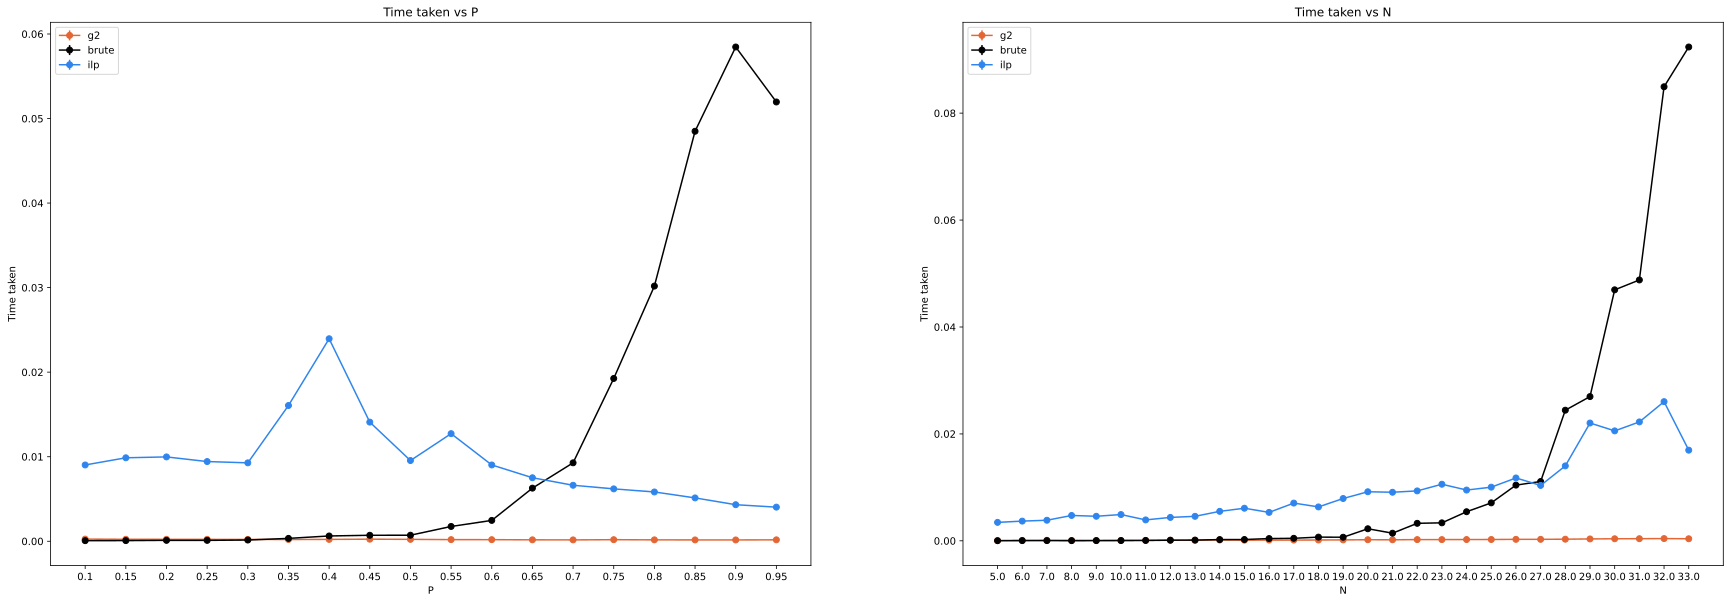

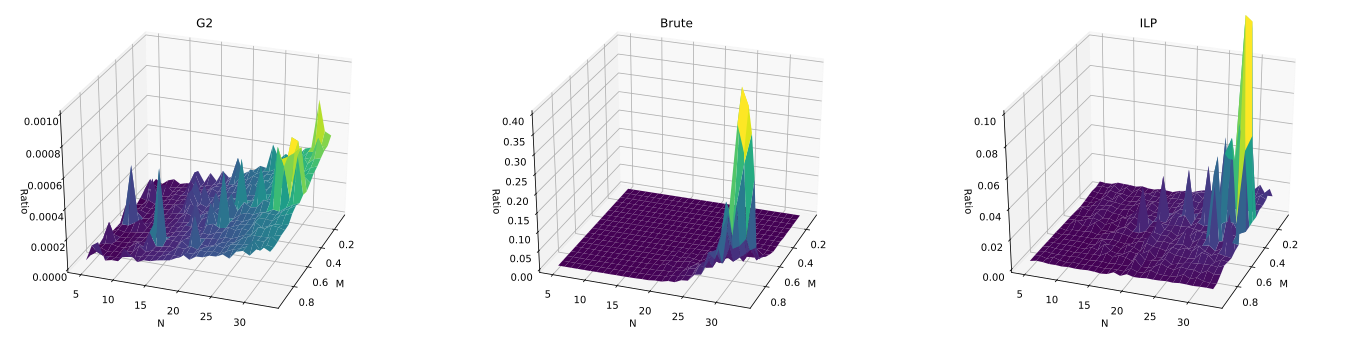

In [ ]:
compare_algos(5, 33, 0.1, 0.95, 0.05, lp="none", COMPARE = "time", WEIGHTED = False)

**Findings:**

- As expected, execution time for the brute force and ILP algorithm increases exponentially with n.
- Execution time for ILP algorithm grows at a smaller rate wrt n than Brute Force.
- For small n, Execution time for ILP is higher than brute force but is overtaken by brute force due to the difference in growth rate.
- ILP and G2 remain constant as p increases.
- Brute force increases with p, since the check function takes more time. 
- G2 algorithm is much more efficient than other exact algorithms.


### Weighted Set Cover


--------------------- Time taken vs N ---------------------


Average                      ... Standard Deviation                    
         N        g2     brute  ...                 g2     brute       ilp
0        5  0.000050  0.000036  ...           0.000010  0.000034  0.001623
1        6  0.000068  0.000047  ...           0.000034  0.000020  0.001552
2        7  0.000089  0.000048  ...           0.000030  0.000011  0.001222
3        8  0.000080  0.000085  ...           0.000017  0.000035  0.000951
4        9  0.000082  0.000086  ...           0.000029  0.000033  0.001454
5       10  0.000111  0.000190  ...           0.000041  0.000084  0.001820
6       11  0.000097  0.000165  ...           0.000024  0.000051  0.002608
7       12  0.000128  0.000386  ...           0.000040  0.000176  0.003284
8       13  0.000117  0.000372  ...           0.000026  0.000102  0.001238
9       14  0.000139  0.000822  ...           0.000042  0.000313  0.003371
10      15  0.000138  0.000860  ...           0.000029  0.000265  0.001416
11      16  0.000155  0.001990  ...           0.000035  0.000741  0.001980
12      17  0.000143  0.001918  ...           0.000014  0.000575  0.006238
13      18  0.000177  0.004453  ...           0.000043  0.001930  0.004983
14      19  0.000173  0.004338  ...           0.000024  0.001507  0.007460
15      20  0.000195  0.009284  ...           0.000030  0.002293  0.001672
16      21  0.000201  0.010042  ...           0.000026  0.003626  0.004699
17      22  0.000222  0.021296  ...           0.000033  0.006550  0.010092
18      23  0.000239  0.022841  ...           0.000036  0.007246  0.004536
19      24  0.000263  0.046368  ...           0.000037  0.012881  0.005596
20      25  0.000269  0.050492  ...           0.000044  0.015884  0.007055
21      26  0.000297  0.111479  ...           0.000051  0.035396  0.008391
22      27  0.000322  0.112841  ...           0.000085  0.033342  0.013330
23      28  0.000322  0.232390  ...           0.000063  0.068236  0.007831
24      29  0.000348  0.241299  ...           0.000071  0.076254  0.009081
25      30  0.000366  0.541815  ...           0.000071  0.172182  0.015255
26      31  0.000384  0.541425  ...           0.000070  0.159663  0.010999
27      32  0.000412  1.153941  ...           0.000082  0.345696  0.029231
28      33  0.000436  1.178442  ...           0.000129  0.341238  0.013031

[29 rows x 8 columns]


--------------------- Time taken vs M ---------------------


Average                      ... Standard Deviation                    
         M        g2     brute  ...                 g2     brute       ilp
0     0.10  0.000253  0.143189  ...           0.000150  0.314545  0.004194
1     0.15  0.000248  0.141242  ...           0.000145  0.288009  0.005869
2     0.20  0.000244  0.152630  ...           0.000142  0.307096  0.004238
3     0.25  0.000248  0.171917  ...           0.000134  0.366899  0.010987
4     0.30  0.000235  0.176162  ...           0.000152  0.365597  0.009273
5     0.35  0.000228  0.193260  ...           0.000132  0.418265  0.015031
6     0.40  0.000215  0.178605  ...           0.000123  0.365917  0.008355
7     0.45  0.000216  0.200573  ...           0.000119  0.416593  0.010170
8     0.50  0.000201  0.181953  ...           0.000112  0.377923  0.024492
9     0.55  0.000200  0.189597  ...           0.000107  0.407184  0.010702
10    0.60  0.000200  0.181351  ...           0.000110  0.394374  0.009812
11    0.65  0.000191  0.161009  ...           0.000093  0.340160  0.011837
12    0.70  0.000183  0.150383  ...           0.000091  0.323315  0.007055
13    0.75  0.000185  0.127387  ...           0.000086  0.270029  0.004190
14    0.80  0.000170  0.109751  ...           0.000086  0.231255  0.002210
15    0.85  0.000193  0.085643  ...           0.000148  0.186815  0.002151
16    0.90  0.000165  0.064789  ...           0.000074  0.135751  0.001289
17    0.95  0.000162  0.053163  ...           0.000076  0.112426  0.001057

[18 rows x 8 columns]

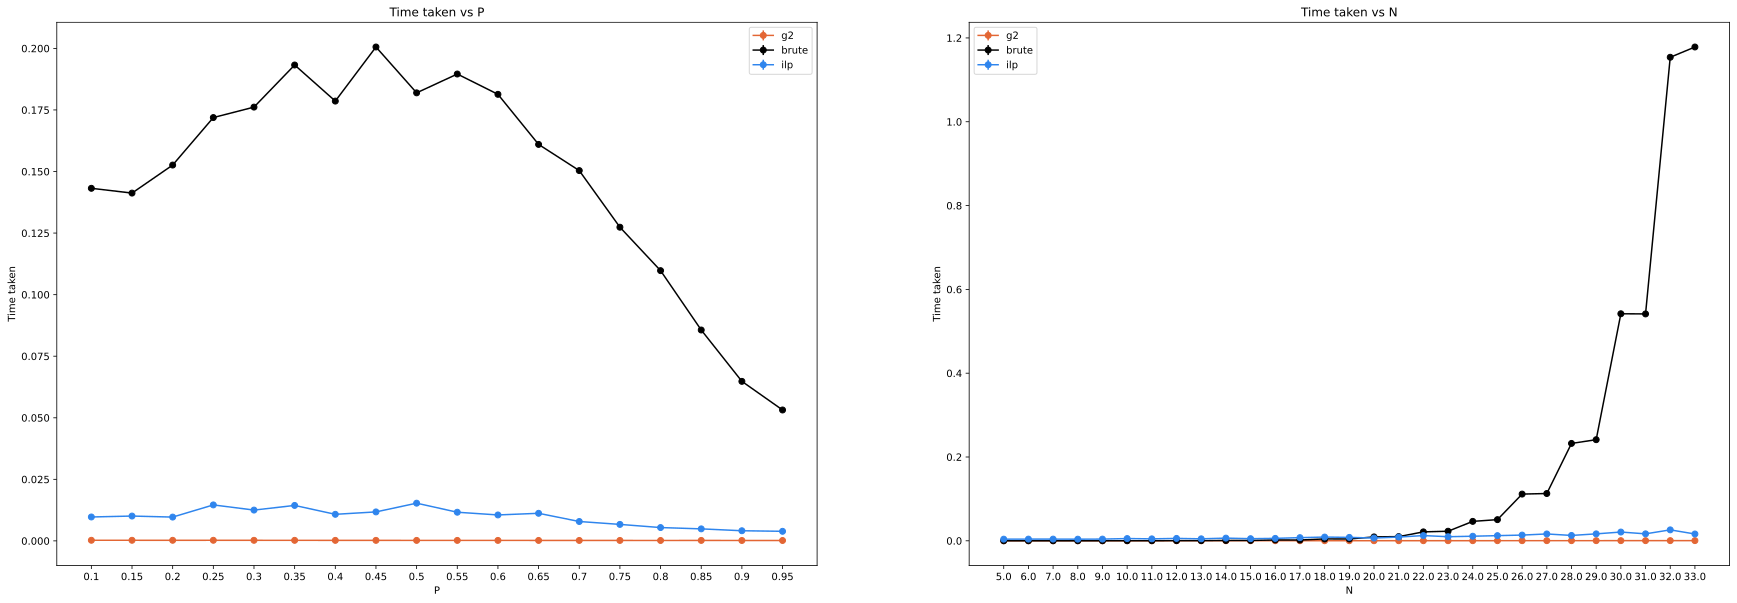

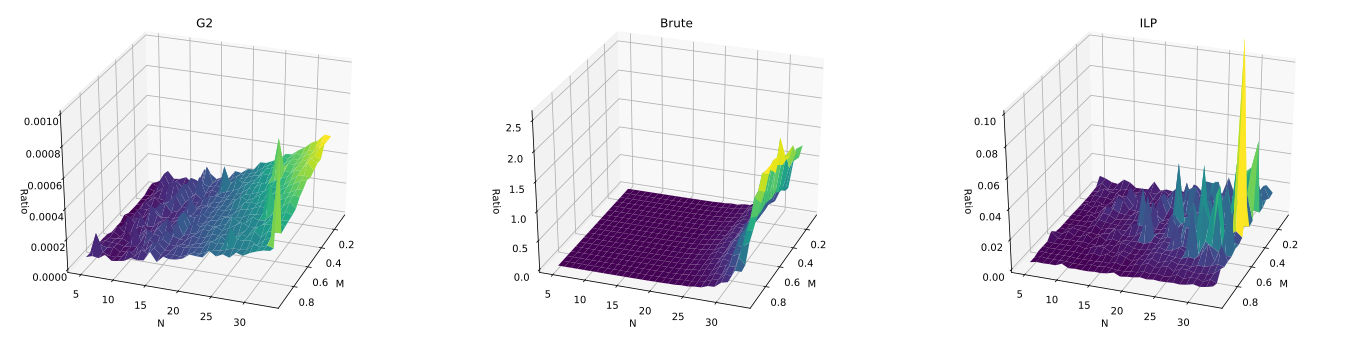

In [ ]:
compare_algos(5, 33, 0.1, 0.95, 0.05, lp="none", COMPARE = "time", WEIGHTED = True)

**Findings:**
- Since we are not early stopping in the weighted set cover, the execution time for brute force is considerably higher.
- As expected, execution time for the brute force increases exponentially with n.
- For small n, Execution time for ILP is higher than brute force but is overtaken by brute force due to the huge difference in growth rate.
- ILP and G2 remain constant as p increases.

## Performance Ratios

### Unweighted Set Cover


--------------------- Ratio of set Covers vs N ---------------------


Average           Standard Deviation          
         N        g2                  N        g2
0        5  1.011785                  5  0.024512
1        6  1.013468                  6  0.027611
2        7  1.020370                  7  0.031682
3        8  1.023990                  8  0.037477
4        9  1.014478                  9  0.028904
5       10  1.027104                 10  0.034539
6       11  1.031061                 11  0.035670
7       12  1.024627                 12  0.035873
8       13  1.020370                 13  0.043004
9       14  1.029557                 14  0.042273
10      15  1.024299                 15  0.034481
11      16  1.029684                 16  0.050457
12      17  1.026431                 17  0.044819
13      18  1.028114                 18  0.036560
14      19  1.043238                 19  0.048144
15      20  1.032203                 20  0.040422
16      21  1.030640                 21  0.034913
17      22  1.040711                 22  0.047010
18      23  1.042857                 23  0.048894
19      24  1.027874                 24  0.036206
20      25  1.031241                 25  0.040139
21      26  1.045330                 26  0.055167
22      27  1.038733                 27  0.045939
23      28  1.049864                 28  0.052439
24      29  1.038157                 29  0.047568
25      30  1.045647                 30  0.048090
26      31  1.026673                 31  0.039027
27      32  1.040995                 32  0.055864


--------------------- Ratio of set Covers vs M ---------------------


Average           Standard Deviation          
         M        g2                  M        g2
0     0.10  1.000000               0.10  0.000000
1     0.15  1.000000               0.15  0.000000
2     0.20  1.000000               0.20  0.000000
3     0.25  1.001623               0.25  0.008435
4     0.30  1.006494               0.30  0.015906
5     0.35  1.006494               0.35  0.015906
6     0.40  1.001623               0.40  0.008435
7     0.45  1.004870               0.45  0.014059
8     0.50  1.015693               0.50  0.022357
9     0.55  1.053301               0.55  0.066891
10    0.60  1.056277               0.60  0.055354
11    0.65  1.059578               0.65  0.051081
12    0.70  1.041504               0.70  0.033888
13    0.75  1.051979               0.75  0.046893
14    0.80  1.056548               0.80  0.031567
15    0.85  1.058987               0.85  0.038083
16    0.90  1.064378               0.90  0.035338
17    0.95  1.073189               0.95  0.033286

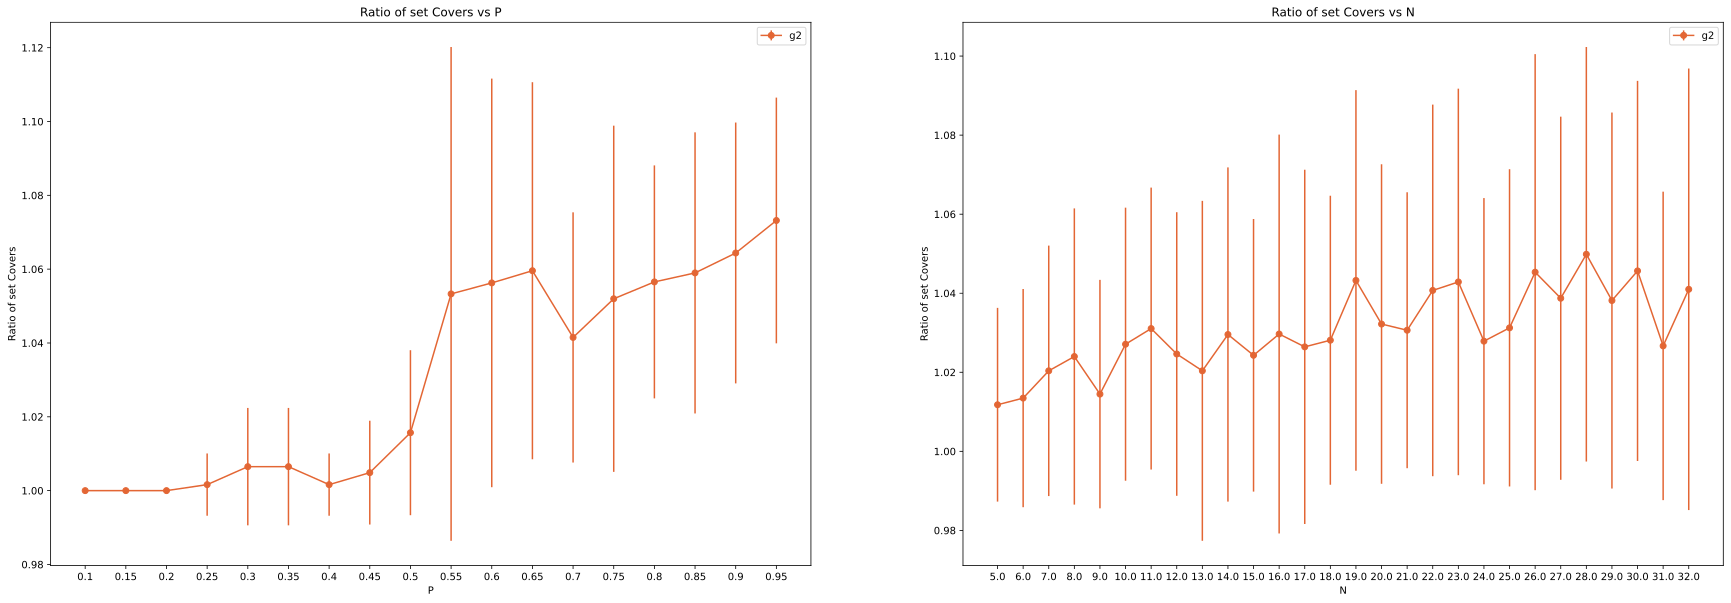

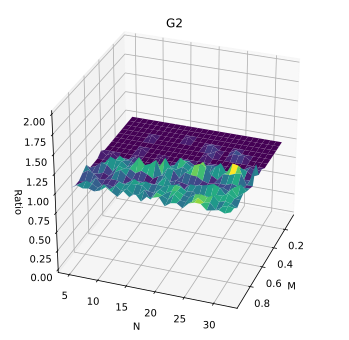

In [ ]:
compare_algos(5, 32, 0.1, 0.95, 0.05, lp = "ilp", COMPARE = "size", WEIGHTED = False)

**Findings:**
- Ratio of G2 to optimal is generally close to 1, so it is a pretty good approximation algorithm.
- There is a slight increase as n (number of elements in universal set) and p (size of subsets in the family of subsets) increase, which is expected.

### Weighted Set Cover


--------------------- Ratio of set Covers vs N ---------------------


Average           Standard Deviation          
         N        g2                  N        g2
0        5  1.046352                  5  0.044351
1        6  1.069125                  6  0.025591
2        7  1.094386                  7  0.034255
3        8  1.076892                  8  0.030174
4        9  1.052811                  9  0.030807
5       10  1.082189                 10  0.038338
6       11  1.080772                 11  0.044670
7       12  1.102044                 12  0.049990
8       13  1.078303                 13  0.039694
9       14  1.073614                 14  0.052437
10      15  1.073480                 15  0.043416
11      16  1.071755                 16  0.039497
12      17  1.080669                 17  0.050294
13      18  1.071093                 18  0.036577
14      19  1.085197                 19  0.050932
15      20  1.056112                 20  0.039374
16      21  1.082464                 21  0.043632
17      22  1.083266                 22  0.050047
18      23  1.072759                 23  0.050074
19      24  1.071670                 24  0.045457
20      25  1.079795                 25  0.060556
21      26  1.072364                 26  0.049837
22      27  1.071654                 27  0.047537
23      28  1.062534                 28  0.039958
24      29  1.068991                 29  0.049028
25      30  1.063887                 30  0.058548
26      31  1.083045                 31  0.052492
27      32  1.074128                 32  0.055813


--------------------- Ratio of set Covers vs M ---------------------


Average           Standard Deviation          
         M        g2                  M        g2
0     0.10  1.031728               0.10  0.042924
1     0.15  1.026993               0.15  0.042407
2     0.20  1.024911               0.20  0.033602
3     0.25  1.044306               0.25  0.033158
4     0.30  1.054556               0.30  0.041765
5     0.35  1.078090               0.35  0.048900
6     0.40  1.087962               0.40  0.049423
7     0.45  1.085267               0.45  0.039557
8     0.50  1.095923               0.50  0.050529
9     0.55  1.091003               0.55  0.050386
10    0.60  1.098291               0.60  0.047997
11    0.65  1.091563               0.65  0.038931
12    0.70  1.084674               0.70  0.029046
13    0.75  1.095641               0.75  0.037095
14    0.80  1.091727               0.80  0.030923
15    0.85  1.091636               0.85  0.032922
16    0.90  1.086266               0.90  0.029422
17    0.95  1.077474               0.95  0.024219

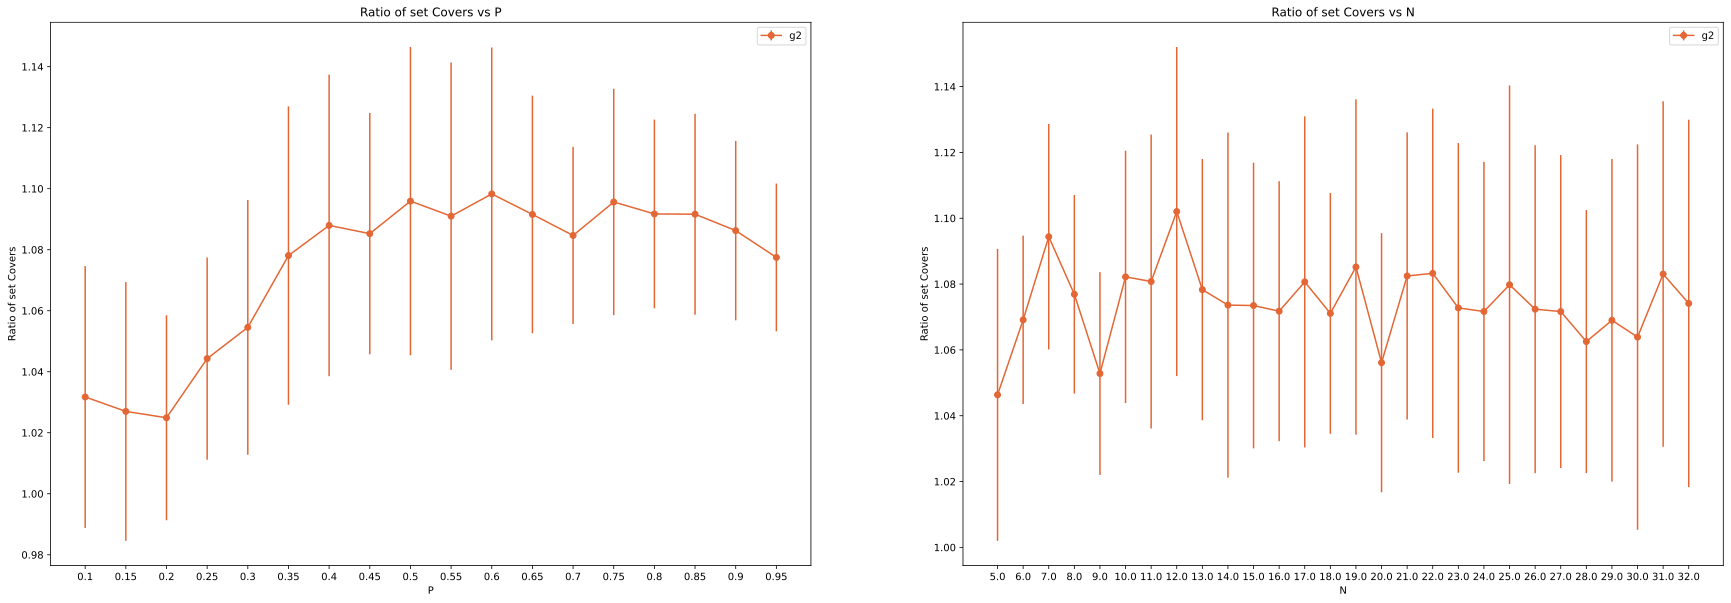

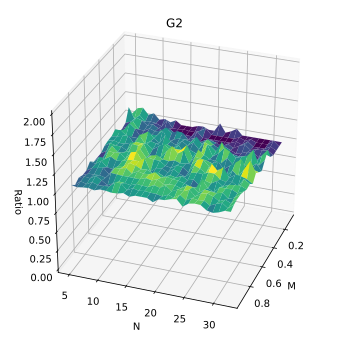

In [ ]:
compare_algos(5, 32, 0.1, 0.95, 0.05, lp = "ilp", COMPARE = "size", WEIGHTED=True)

**Findings:**
- Ratio of weighted G2 to optimal is generally close to 1, so it is a pretty good approximation algorithm.
- Even as n (number of elements in universal set) and p (size of subsets in the family of subsets) increase, the ratio of weights_G2 / weights_optimal does not change much.